---
title: Classification
format:
  html:
      embed-resources: true
      code-fold: true
      cite-method: biblatex
---

## Introduction to Classification Decision Trees

*Note: Decision Tree introduction is on Regression tab.* 

For classification Decision Trees, the target variable takes a discrete set of values. Unlike regression trees where the aim is to predict a generalized value for the target variable, classification trees attempt to assign class labels to records based on a given set of labels in training data. Thus, each leaf is a particular class label, serving as a prediction for all records that follow its respective sequence of conditions.

## Classification Trees for Record Data

### Class Distribution

The record data we will be using comes from the IPUMS dataset containing results from the US Census Bureau. Our target variable will be `commute_method`, which each respondents answer to what their primary mode of transportation is for work. As this data has been cleaned, this categorical variable is portrayed via text with the following classes, with their respective totals:

- Private Vehicle - 103458 answers
- Public Transit - 18319
- Bicycle - 1853
- Walked - 8582
- Worked from Home - 44857
- Other - 2517

The following is a visualization of the class distribution:

In [ ]:
ipums <- read.csv("../../data/cleaned_data/ipums_cleaned.csv")
barplot(table(ipums$transportation_type), main="Distribution of Commute Methods",
   xlab="Commute Method", ylab="Number of Responses", 
        cex.axis=.8, cex.names=.8)

![Distribution of Commute Methods](../../images/bar1.png)

### Over/under-sampling

As we can see the bar graph, `Private Vehicle` and `Worked from Home` make up a significant majority of the data in this set. This creates problems for classification, as the algorithm will tend to predict only those classes to maximize accuracy. Thus, it is common practice to under-sample from those classes to gain better insights.

While this will produce a tree that better represents predictions for each class, it is important to note that this is not the distribution of the original data. For this purpose, we will remove a random sample of 85,000 `Private Vehicle` responses and 26,000 `Worked from Home` responses. The code for that is below, with the new class distribution:

In [2]:
ipums2 <- ipums[-sample(which(ipums$commute_method=="Private Vehicle"), 85000),]
ipums2 <- ipums2[-sample(which(ipums2$commute_method=="Worked From Home"), 26000),]
table(ipums2$commute_method)

SyntaxError: invalid syntax (1274090368.py, line 2)

![Distribution of Commute Methods](../../images/bar3.png)

### Applying the Model

After re-sizing the data, we can now split the records into training and testing sets and generate a decision tree. This is done using the `rpart` and `rattle` libraries in R. The code and outputs are below:

In [ ]:
train_size2 <- floor(nrow(ipums2)*(.8))
test_size2 <- nrow(ipums2) - train_size2
set.seed(1000)
train2 <- ipums2[sample(nrow(ipums2), train_size2,replace=FALSE),]
test2 <- ipums2[-sample(nrow(ipums2), train_size2,replace=FALSE),]
ipums_tree2 <- rpart(transportation_type ~ city_population_00s + age + income, data = train2, method="class")
fancyRpartPlot(ipums_tree2,main = "Commute Method Decision Tree")

![Commute Methods Decision Tree](../../images/class1.png)

The main things to note from this tree are the variables included in each condition. Firstly, we can notice that respondents with lower incomes are more likely to be placed in the `Public Transit` class than those with high incomes. Additionally, those in cities with greater populations are more likely to take `Public Transit` according to this data.

### Results

The results of this classification tree are below:

In [ ]:
library(cvms)
prediction2 = predict(ipums_tree2, test2[,-which(names(test) %in% c("transportation_type"))], type="class")
conf_mat <- confusion_matrix(targets = test2$commute_method,
                             predictions = prediction2)
plot_confusion_matrix(conf_mat$`Confusion Matrix`[[1]], rotate_y_text = FALSE)

![Confusion Matrix](../../images/class_confusion.png)

While it is notable that no predictions went to the `Walked`, `Bicycle`, and `Worked From Home` classes, we can still gather information from the accuracy given by this confusion matrix. Ultimately, values on the diagonals are the largest values for each of the three populated rows, indicating relative accuracy from the model.

## Classification Trees for Text Data

*Note: Code for this section partially repurposed from DSAN-5000 Lab 3.2*

In order to create classification trees for text data, we will pull in Yelp reviews data that we had cleaned prior. As in previous steps, the `nltk` package will be particularly useful for lemmatizing our text, removing stopwords and stoplemmas, and ensuring only English letters are present in the data. The code for this is below, along with a word cloud of the entire dataset to visualize the most common words used by Yelp reviewers of public transit systems.

100%|██████████| 2435/2435 [00:30<00:00, 78.62it/s] 


Text(0.5, 1.0, 'Yelp Word Cloud')

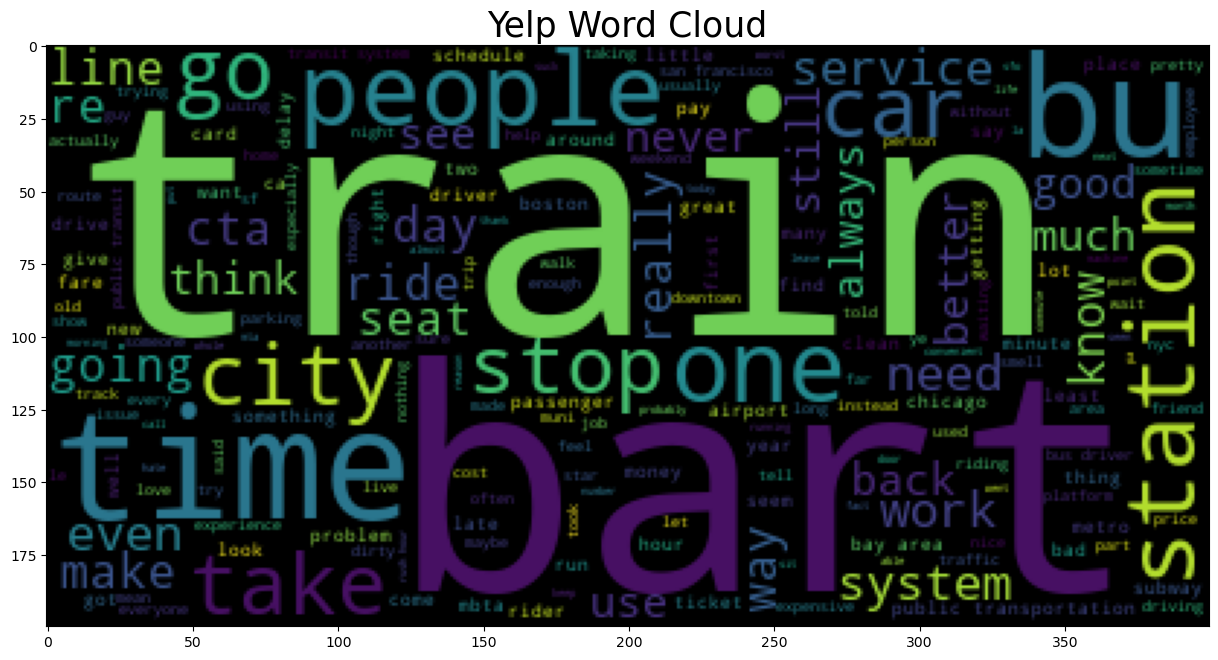

In [57]:
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import accuracy_score
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm import tqdm
import string
from collections import Counter
tqdm.pandas()
token_counter = Counter()
import pandas as pd
yelp=pd.read_csv('../../data/cleaned_data/yelp_cleaned.csv') 
lemmatizer = WordNetLemmatizer()
custom_stoplemmas = [
    'be',
    'ir',
    'll',
    'nt',
    'quot',
    'rd',
    's',
    've'
]

def remove_special_chars(token):
  return token.translate(str.maketrans('', '', string.punctuation))

def remove_digits(token):
  return ''.join([c for c in token if not c.isdigit()])

def clean_review(review_text):
  review_cleaned = review_text.lower()
  review_sents = sent_tokenize(review_cleaned)
  clean_sents = []
  for cur_sent in review_sents:
    sent_tokens = word_tokenize(cur_sent)
    sent_tokens_cleaned = [t for t in sent_tokens if t not in stopwords.words('english')]
    sent_tokens_cleaned = [remove_digits(t) for t in sent_tokens_cleaned]
    sent_tokens_cleaned = [t.replace("-", " ") for t in sent_tokens_cleaned]
    sent_tokens_cleaned = [remove_special_chars(t) for t in sent_tokens_cleaned]
    sent_tokens_cleaned = [t for t in sent_tokens_cleaned if len(t) > 0]
    sent_tokens_cleaned = [lemmatizer.lemmatize(t) for t in sent_tokens_cleaned]
    sent_tokens_cleaned = [t for t in sent_tokens_cleaned if t not in custom_stoplemmas]
    token_counter.update(sent_tokens_cleaned)
    clean_sent = ' '.join(sent_tokens_cleaned)
    clean_sents.append(clean_sent)
  review_final = ". ".join(clean_sents)
  return review_final
yelp['Review_clean'] = yelp['Review'].progress_apply(clean_review)
import wordcloud
import matplotlib.pyplot as plt
wordcloud = wordcloud.WordCloud(min_word_length = 2,max_words = 200).generate(yelp['Review_clean'].str.cat())
fig = plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.title('Yelp Word Cloud',fontsize = 25)


### Class Distribution

As noticed in Exploratory Data Analysis, the data for Yelp ratings has a significantly imbalanced distribution, with ratings of `1` having more than twice the frequency of any other rating class. Thus, for supervised learning, we will once again perform under-sampling to even out this distribution by removing 500 random reviews with a rating of `1`. It is important to reiterate that while this will ultimately produce improved results for classification, this no longer represents the true class distribution from the original data. This process's code, along with the new class distribution, is below.

<Axes: xlabel='Rating', ylabel='count'>

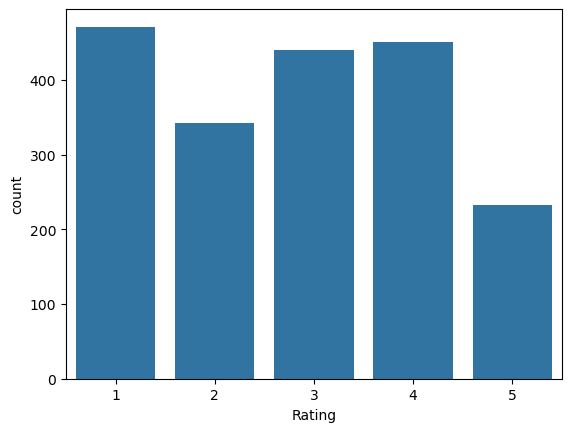

In [58]:
import seaborn as sns
yelp = yelp.drop(yelp[yelp['Rating']==1].sample(n=500).index)
rating_order = [1,2,3,4,5]
sns.countplot(x = "Rating", data = yelp, order = rating_order)

Upon preparing the data for supervised learning, we can now create a corpus and vectore the data. The next step will be to split the data into training and testing datasets using the `sklearn` package.

In [59]:
corpus=yelp["Review"].to_list()
y=yelp["Rating"].to_numpy()
vectorizer=CountVectorizer(min_df=0.001)   

Xs  =  vectorizer.fit_transform(corpus)   
X=np.array(Xs.todense())

maxs=np.max(X,axis=0)
X=np.ceil(X/maxs)

from sklearn.model_selection import train_test_split
test_ratio=0.2

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=0)
y_train=y_train.flatten()
y_test=y_test.flatten()

For classifying text data, we will be using the `KNeighborsClassifier()` function in `sklearn`. To use this, we must initialize a model with a specified number of "neighbors" for the algorithm to take as an input. Therefore, we will use a loop to determine the optimal number of neighbors to set. The function for this is below, where we will iterate over values `1` to `40` as potential input values.

In [60]:
from sklearn.neighbors import KNeighborsClassifier


# HYPER PARAMETER SEARCH FOR OPTIMAL NUMBER OF NEIGHBORS 
num_neighbors=[]
train_accuracy=[]
test_accuracy=[]

# LOOP OVER HYPER-PARAM
for i in range(1,40): 
    model = KNeighborsClassifier(n_neighbors=i)

    model.fit(x_train,y_train)

    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)

    acc1=accuracy_score(y_train, yp_train)*100
    acc2=accuracy_score(y_test, yp_test)*100

    num_neighbors.append(i)
    train_accuracy.append(acc1)
    test_accuracy.append(acc2)

Text(0, 0.5, 'Training (black) and test (blue) accuracy')

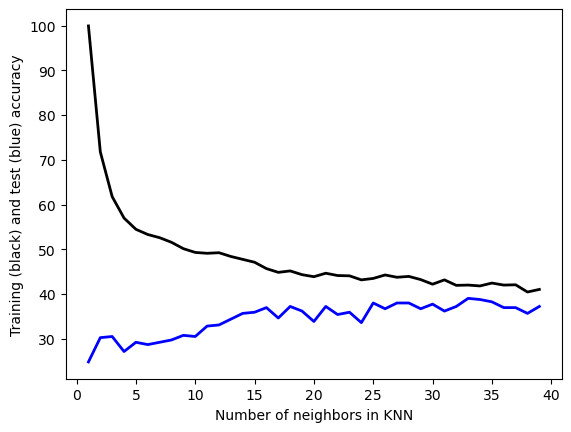

In [61]:
plt.plot(num_neighbors,train_accuracy ,linewidth=2, color='k')
plt.plot(num_neighbors,test_accuracy ,linewidth=2, color='b')

plt.xlabel("Number of neighbors in KNN")
plt.ylabel("Training (black) and test (blue) accuracy")

With this convergence plot, we are looking for the value on the x-axis at which the blue line (the test accuracy) stops climbing (i.e., where it converges with the black line). This appars to happen at around `33`, so we will select `33` as the input for number of neighbors in our K-nearest neighbors algorithm.

In [62]:
def report(y,ypred):
      print("Accuracy:",accuracy_score(y, ypred)*100)
      print("Number of mislabeled points out of a total %d points = %d"
            % (y.shape[0], (y != ypred).sum()))
def print_model_summary():
      yp_train = model.predict(x_train)
      yp_test = model.predict(x_test)

      print("ACCURACY CALCULATION\n")

      print("TRAINING SET:")
      report(y_train,yp_train)

      print("\nTEST SET (UNTRAINED DATA):")
      report(y_test,yp_test)

      print("\nCHECK FIRST 20 PREDICTIONS")
      print("TRAINING SET:")
      print(y_train[0:20])
      print(yp_train[0:20])
      print("ERRORS:",yp_train[0:20]-y_train[0:20])

      print("\nTEST SET (UNTRAINED DATA):")
      print(y_test[0:20])
      print(yp_test[0:20])
      print("ERRORS:",yp_test[0:20]-y_test[0:20])

model = KNeighborsClassifier(n_neighbors=33)

model.fit(x_train,y_train)
print_model_summary()

ACCURACY CALCULATION

TRAINING SET:
Accuracy: 41.98966408268734
Number of mislabeled points out of a total 1548 points = 898

TEST SET (UNTRAINED DATA):
Accuracy: 39.01808785529715
Number of mislabeled points out of a total 387 points = 236

CHECK FIRST 20 PREDICTIONS
TRAINING SET:
[1 3 1 5 4 3 3 1 1 1 4 3 5 3 2 4 4 4 3 1]
[1 3 4 3 1 3 3 1 1 1 3 4 4 3 1 1 1 4 3 1]
ERRORS: [ 0  0  3 -2 -3  0  0  0  0  0 -1  1 -1  0 -1 -3 -3  0  0  0]

TEST SET (UNTRAINED DATA):
[2 2 4 5 3 3 1 5 2 5 4 4 1 2 1 2 3 1 5 1]
[3 1 3 1 4 3 3 4 4 1 4 4 1 1 1 1 5 1 4 3]
ERRORS: [ 1 -1 -1 -4  1  0  2 -1  2 -4  0  0  0 -1  0 -1  2  0 -1  2]


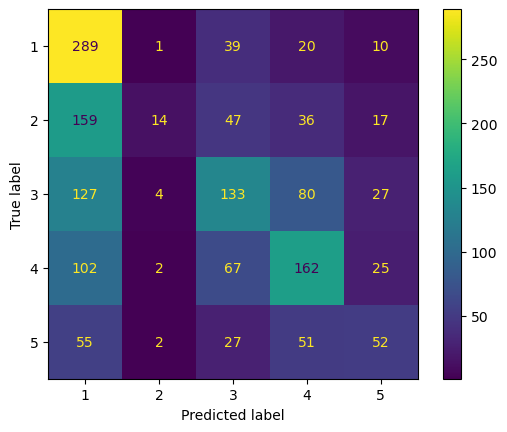

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train, model.predict(x_train), labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

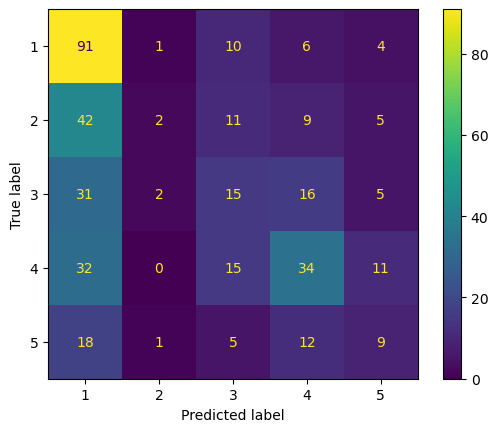

In [64]:
cm = confusion_matrix(y_test, model.predict(x_test), labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

The above results show that classification is somewhat effective in predicting Rating values from the text. An accuracy of around 40 for both the train and test datasets is clearly much better than random chance, although it is still more likely than not that a prediction will be incorrect. From looking at the confusion matrices, we can see one of the reasons why. With K-nearest neighbors, it appears that the model over-predicted ratings of `1`, since that was the mode. Additionally, the text may be more pronounced in that group since it is an extreme--there may be more noticeable characteristics of a very poor review than of any other group. However, we do see more pronounced cells on the diagonal, which indicates some degree of predictive value from this supervised learning technique.

## Conclusions

To go back to our research questions, the information from our record can give us insight into who is affected by the performance and ubiquity of public transit systems. As our record data shows, public transit is disproportionally used as a means of commuting to work by people in larger cities with lower incomes. Thus, there is societal value in upholding these institutions, as they offer services to those who often depend on them.

Our text data was less definitive in its ability to produce meaningful classifications, but we can say that due to the somewhat significant accuracy, we can conclude that there are textual characteristics associated with different rating values.